# Track Linearization: Working with 1D Environments

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand when and why to use 1D linearization
- Create linearized track environments with GraphLayout
- Convert between N-D position coordinates and 1D linear position
- Work with complex maze structures (plus maze, figure-8)
- Understand the difference between 1D and N-D environments
- Use linearization for trajectory-dependent neural analysis

**Estimated time: 25-30 minutes**

## Why 1D Linearization?

Many experiments use track-based environments where movement is constrained to specific paths:

- **Linear tracks**: Simple back-and-forth running
- **W-tracks / Z-tracks**: Alternation tasks
- **Plus mazes**: Four-arm radial structures
- **Figure-8 mazes**: Continuous alternation
- **T-mazes**: Left/right choice tasks

For these environments, **linearization** maps 2D positions onto a 1D track coordinate. This is essential for:

- **Trajectory-dependent analysis**: Distinguish left vs right journeys on the same physical location
- **Place field analysis**: Better capture spatially-tuned neurons on tracks
- **Sequence detection**: Identify replay and theta sequences
- **Directional coding**: Separate opposing movement directions

The `GraphLayout` engine handles this automatically!

## Setup

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from neurospatial import Environment

np.random.seed(42)
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 11

## Example 1: Simple Linear Track

Let's start with the simplest case: a straight linear track.

In [22]:
# Create position data for a linear track (back and forth)
track_length = 100.0  # cm
n_laps = 5
samples_per_lap = 200
n_samples = n_laps * samples_per_lap

# Position along track (oscillates back and forth)
t = np.linspace(0, n_laps * 2 * np.pi, n_samples)
x_position = (np.sin(t) + 1) * 50  # Oscillates between 0 and 100

# Y position is constant (straight track at y=0)
y_position = np.zeros_like(x_position)

# Add small noise
y_position += np.random.randn(n_samples) * 0.5

linear_track_data = np.column_stack([x_position, y_position])

print(f"Generated {n_samples} samples for linear track")
print(
    f"Track extent: X=[{x_position.min():.1f}, {x_position.max():.1f}], Y=[{y_position.min():.1f}, {y_position.max():.1f}]"
)

Generated 1000 samples for linear track
Track extent: X=[0.0, 100.0], Y=[-1.6, 1.9]


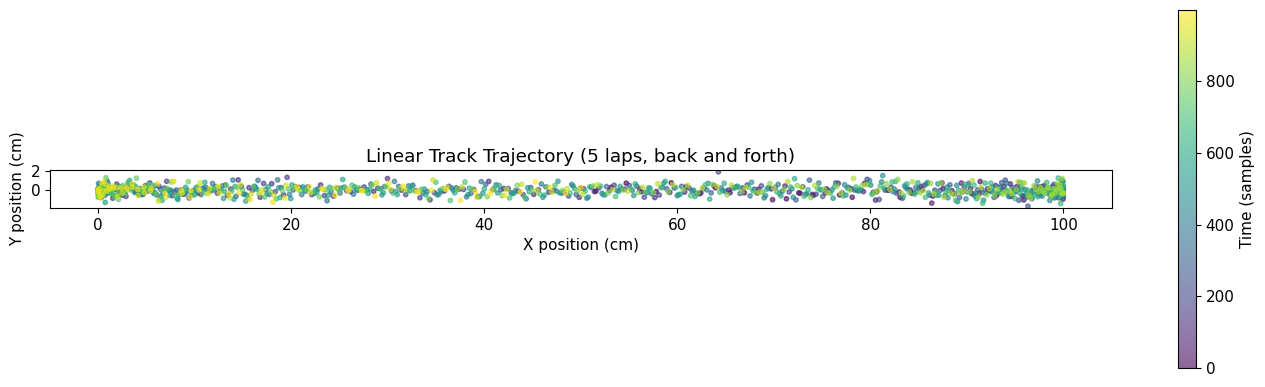

In [23]:
# Visualize the trajectory
fig, ax = plt.subplots(figsize=(14, 4))

scatter = ax.scatter(
    linear_track_data[:, 0],
    linear_track_data[:, 1],
    c=np.arange(n_samples),
    cmap="viridis",
    s=10,
    alpha=0.6,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Linear Track Trajectory (5 laps, back and forth)")
ax.set_aspect("equal")
plt.colorbar(scatter, ax=ax, label="Time (samples)")
plt.tight_layout()
plt.show()

### Creating a Linearized Environment

To create a 1D linearized environment, use `Environment.from_graph()`. This requires the `track-linearization` package.

**Note**: The `from_graph()` method automatically handles track linearization for you.

In [24]:
# For a linear track, create a simple graph with two nodes (endpoints) and one edge
linear_track_graph = nx.Graph()
linear_track_graph.add_node(0, pos=(0.0, 0.0))
linear_track_graph.add_node(1, pos=(100.0, 0.0))
linear_track_graph.add_edge(0, 1, edge_id=0)

# Add distance attribute to edge (required by GraphLayout)
for u, v in linear_track_graph.edges():
    pos_u = np.array(linear_track_graph.nodes[u]["pos"])
    pos_v = np.array(linear_track_graph.nodes[v]["pos"])
    linear_track_graph.edges[u, v]["distance"] = np.linalg.norm(pos_v - pos_u)

# Define edge order (list of edges to traverse)
edge_order = [(0, 1)]

# Create 1D linearized environment
env_1d = Environment.from_graph(
    graph=linear_track_graph,
    edge_order=edge_order,
    edge_spacing=0.0,  # No spacing between edges for single edge
    bin_size=5.0,  # 5 cm bins along track
    name="LinearTrack",
)

print("1D Environment Created!")
print(f"Is 1D: {env_1d.is_1d}")
print(f"Number of bins: {env_1d.n_bins}")
print(f"Layout type: {env_1d.layout._layout_type_tag}")

1D Environment Created!
Is 1D: True
Number of bins: 20
Layout type: Graph


### Understanding 1D vs 2D Environments

The key difference:

- **2D/N-D Environment**: Bins represent regions in physical space
- **1D Environment**: Bins represent positions along a trajectory

**Critical insight**: On a linear track, the same physical location (e.g., X=50 cm) is visited twice per lap (going left vs going right). A 1D linearized environment gives these **different bin indices** based on trajectory!

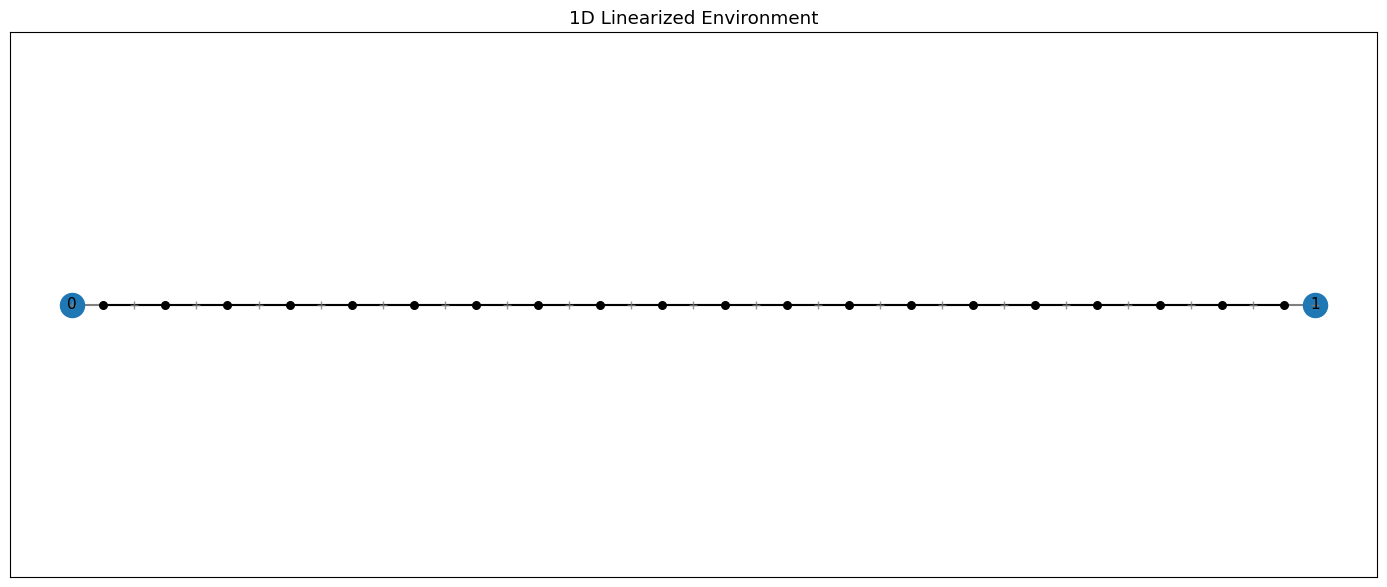


Bin centers shape: (20, 2)
Dimension ranges: ((np.float64(2.5), np.float64(97.5)), (np.float64(0.0), np.float64(0.0)))


In [25]:
if env_1d is not None:
    # Visualize the 1D environment
    fig, ax = plt.subplots(figsize=(14, 6))

    env_1d.plot(ax=ax, show_connectivity=True)

    ax.set_title("1D Linearized Environment")
    plt.tight_layout()
    plt.show()

    print(f"\nBin centers shape: {env_1d.bin_centers.shape}")
    print(f"Dimension ranges: {env_1d.dimension_ranges}")
else:
    print("Skipping visualization (track-linearization not available)")

## Converting Between N-D and Linear Coordinates

1D environments provide special methods:

- **`to_linear(nd_position)`**: Convert 2D position → 1D linear coordinate
- **`linear_to_nd(linear_position)`**: Convert 1D coordinate → 2D position

These methods consider trajectory, not just spatial location!

In [26]:
if env_1d is not None and env_1d.is_1d:
    # Map trajectory to linear position
    linear_positions = env_1d.to_linear(linear_track_data)

    print(f"Linear positions shape: {linear_positions.shape}")
    print(
        f"Linear position range: [{linear_positions.min():.1f}, {linear_positions.max():.1f}]"
    )

    # Show how same X position maps to different linear positions
    mid_track_x = 50.0
    mid_indices = np.where(np.abs(linear_track_data[:, 0] - mid_track_x) < 1.0)[0][:10]

    print(f"\nSame X position ({mid_track_x} cm) at different times:")
    for idx in mid_indices[:5]:
        print(
            f"  Time {idx}: 2D pos = {linear_track_data[idx]}, Linear pos = {linear_positions[idx]:.1f}"
        )
else:
    print("Skipping coordinate conversion (track-linearization not available)")

Linear positions shape: (1000,)
Linear position range: [0.0, 100.0]

Same X position (50.0 cm) at different times:
  Time 0: 2D pos = [50.          0.24835708], Linear pos = 50.0
  Time 100: 2D pos = [49.84276339 -0.70768537], Linear pos = 49.8
  Time 200: 2D pos = [50.31447167  0.17889368], Linear pos = 50.3
  Time 300: 2D pos = [49.52829639 -0.41449751], Linear pos = 49.5
  Time 399: 2D pos = [49.05663476  0.61890816], Linear pos = 49.1


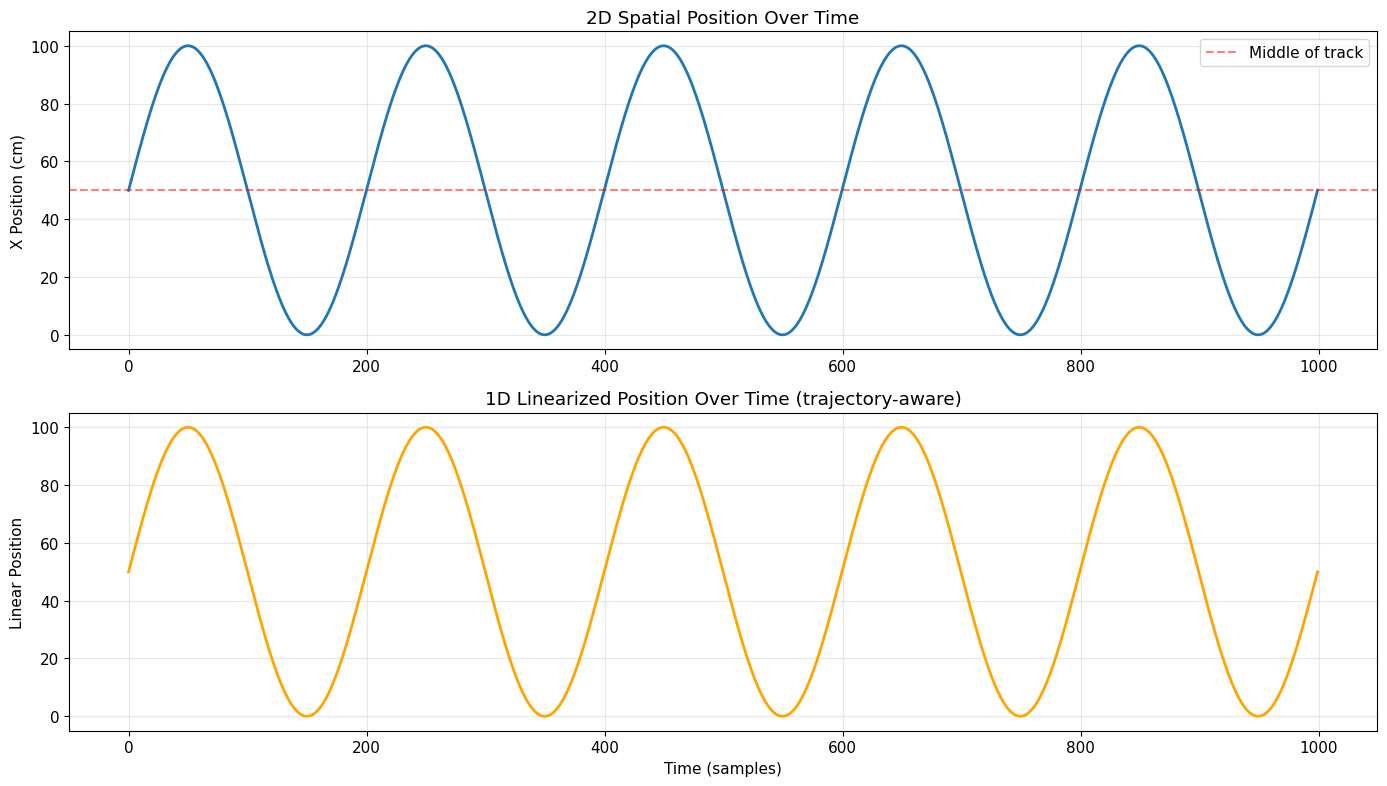


Key insight: Linear position continuously increases,
even when X position oscillates back and forth!


In [27]:
if env_1d is not None and env_1d.is_1d:
    # Visualize linear position over time
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Top: 2D X position over time
    axes[0].plot(linear_track_data[:, 0], linewidth=2)
    axes[0].set_ylabel("X Position (cm)")
    axes[0].set_title("2D Spatial Position Over Time")
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(50, color="red", linestyle="--", alpha=0.5, label="Middle of track")
    axes[0].legend()

    # Bottom: 1D linear position over time
    axes[1].plot(linear_positions, linewidth=2, color="orange")
    axes[1].set_xlabel("Time (samples)")
    axes[1].set_ylabel("Linear Position")
    axes[1].set_title("1D Linearized Position Over Time (trajectory-aware)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nKey insight: Linear position continuously increases,")
    print("even when X position oscillates back and forth!")
else:
    print("Skipping visualization (track-linearization not available)")

## Example 2: Plus Maze

Now let's look at a more complex structure: a plus maze with four arms.

In [28]:
# Create plus maze structure
# Center at (50, 50), arms extend 40 cm in each direction

center = np.array([50.0, 50.0])
arm_length = 40.0

# Define arm endpoints
north_end = center + np.array([0, arm_length])
east_end = center + np.array([arm_length, 0])
south_end = center + np.array([0, -arm_length])
west_end = center + np.array([-arm_length, 0])

# Generate trajectory: start at south, go to center, explore arms
trajectory_segments = [
    # Start at south arm
    (south_end, center),
    # Go to north arm and back
    (center, north_end),
    (north_end, center),
    # Go to east arm and back
    (center, east_end),
    (east_end, center),
    # Go to west arm and back
    (center, west_end),
    (west_end, center),
    # Return to south
    (center, south_end),
]


# Create smooth trajectory
def create_smooth_segment(start, end, n_points=100):
    """Create smooth trajectory between two points."""
    alphas = np.linspace(0, 1, n_points)
    points = np.outer(1 - alphas, start) + np.outer(alphas, end)
    # Add small noise
    points += np.random.randn(n_points, 2) * 0.5
    return points


plus_maze_data = []
for start, end in trajectory_segments:
    segment = create_smooth_segment(start, end, n_points=100)
    plus_maze_data.append(segment)

plus_maze_data = np.vstack(plus_maze_data)

print(f"Generated {len(plus_maze_data)} samples for plus maze")
print("Trajectory visits all 4 arms")

Generated 800 samples for plus maze
Trajectory visits all 4 arms


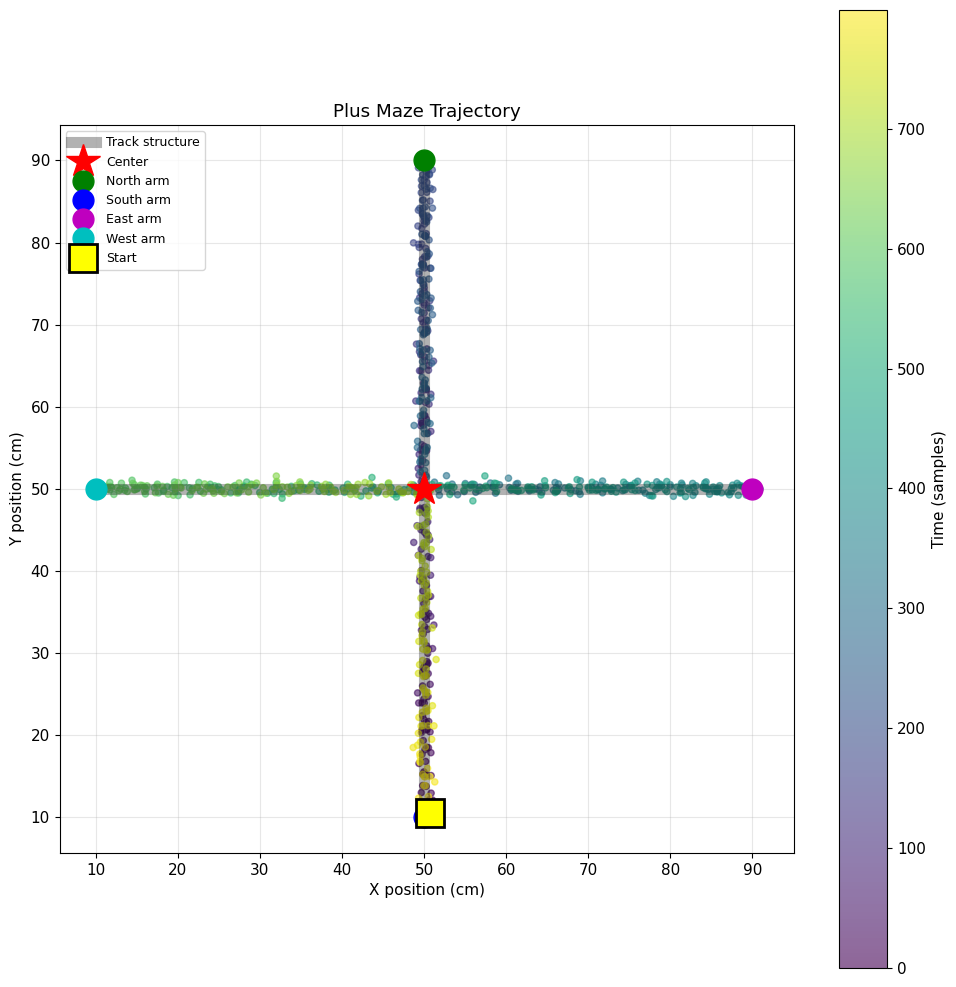

In [29]:
# Visualize plus maze trajectory
fig, ax = plt.subplots(figsize=(10, 10))

# Draw maze structure
ax.plot(
    [center[0], north_end[0]],
    [center[1], north_end[1]],
    "k-",
    linewidth=8,
    alpha=0.3,
    label="Track structure",
)
ax.plot(
    [center[0], south_end[0]], [center[1], south_end[1]], "k-", linewidth=8, alpha=0.3
)
ax.plot(
    [west_end[0], east_end[0]], [center[1], center[1]], "k-", linewidth=8, alpha=0.3
)

# Plot trajectory
scatter = ax.scatter(
    plus_maze_data[:, 0],
    plus_maze_data[:, 1],
    c=np.arange(len(plus_maze_data)),
    cmap="viridis",
    s=20,
    alpha=0.6,
)

# Mark center and arm endpoints
ax.plot(center[0], center[1], "r*", markersize=25, label="Center")
ax.plot(north_end[0], north_end[1], "go", markersize=15, label="North arm")
ax.plot(south_end[0], south_end[1], "bo", markersize=15, label="South arm")
ax.plot(east_end[0], east_end[1], "mo", markersize=15, label="East arm")
ax.plot(west_end[0], west_end[1], "co", markersize=15, label="West arm")

# Mark start
ax.plot(
    plus_maze_data[0, 0],
    plus_maze_data[0, 1],
    "ks",
    markersize=20,
    label="Start",
    markeredgewidth=2,
    markerfacecolor="yellow",
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Plus Maze Trajectory")
ax.set_aspect("equal")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label="Time (samples)")
plt.tight_layout()
plt.show()

### Creating Plus Maze Environment with Graph

For complex mazes, you can provide an explicit track graph structure:

In [30]:
# Define track graph structure
# Nodes are named locations, edges are track segments

track_graph = nx.Graph()

# Add nodes with 2D positions
track_graph.add_node("center", pos=center)
track_graph.add_node("north", pos=north_end)
track_graph.add_node("south", pos=south_end)
track_graph.add_node("east", pos=east_end)
track_graph.add_node("west", pos=west_end)

# Add edges (track segments) with sequential edge_ids
track_graph.add_edge("center", "north", edge_id=0)
track_graph.add_edge("center", "south", edge_id=1)
track_graph.add_edge("center", "east", edge_id=2)
track_graph.add_edge("center", "west", edge_id=3)

# Add distance attributes to edges (required by GraphLayout)
for u, v in track_graph.edges():
    pos_u = np.array(track_graph.nodes[u]["pos"])
    pos_v = np.array(track_graph.nodes[v]["pos"])
    track_graph.edges[u, v]["distance"] = np.linalg.norm(pos_v - pos_u)

print(
    f"Track graph: {track_graph.number_of_nodes()} nodes, {track_graph.number_of_edges()} edges"
)
print(f"Nodes: {list(track_graph.nodes())}")

Track graph: 5 nodes, 4 edges
Nodes: ['center', 'north', 'south', 'east', 'west']


In [31]:
# Define edge order for plus maze (order in which edges are traversed)
# For a plus maze, we traverse all 4 arms from the center
plus_maze_edge_order = [
    ("center", "north"),
    ("center", "south"),
    ("center", "east"),
    ("center", "west"),
]

# Create 1D environment for plus maze
env_plus = Environment.from_graph(
    graph=track_graph,
    edge_order=plus_maze_edge_order,
    edge_spacing=0.0,  # No spacing between edges
    bin_size=5.0,
    name="PlusMaze",
)

print("Plus Maze 1D Environment Created!")
print(env_plus.info())

Plus Maze 1D Environment Created!
Environment Information

Name: PlusMaze
Layout Type: Graph
Dimensions: 2
Number of Bins: 32

Spatial Extent:
  Dimension 0: [12.50, 87.50] (range: 75.00)
  Dimension 1: [12.50, 87.50] (range: 75.00)

Bin Sizes:
  Dimension 0: 5.00

Regions: None

Linearization: Available (1D environment)



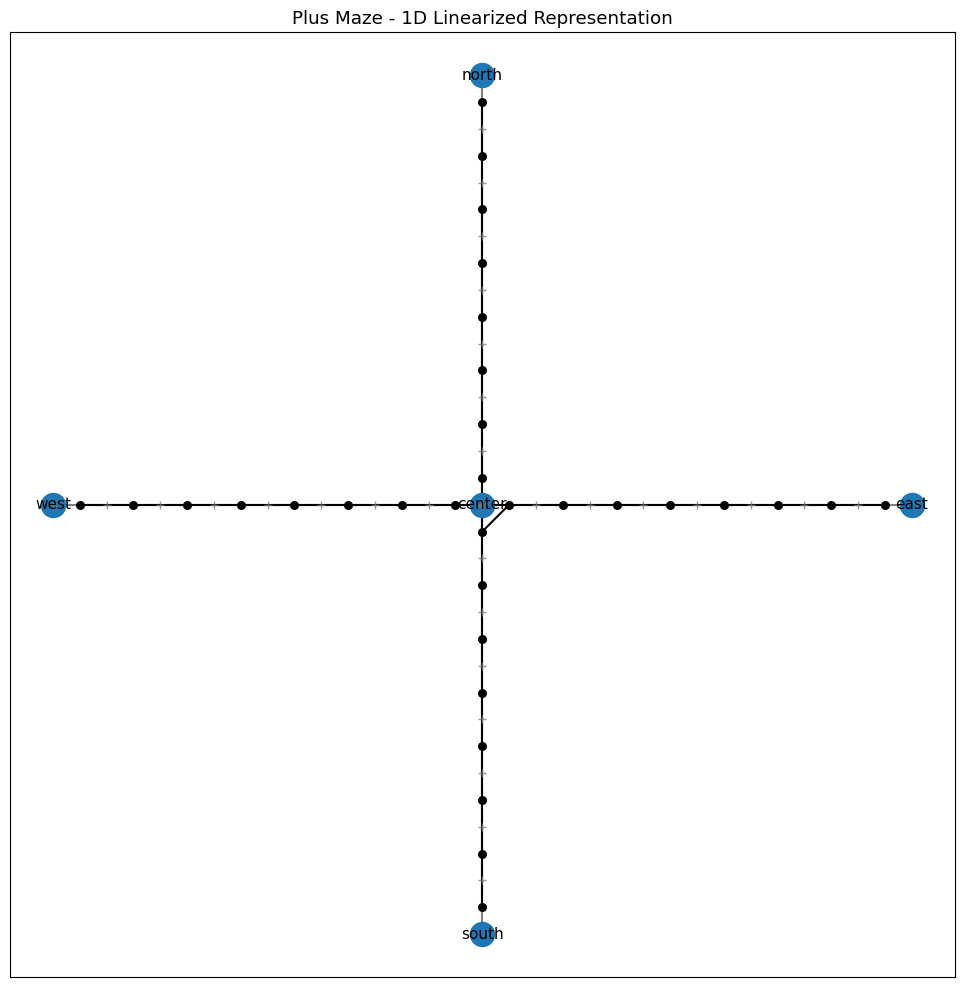


Note: Center appears multiple times in linearization!
This captures the different trajectories through the center.


In [32]:
# Visualize the linearized plus maze
fig, ax = plt.subplots(figsize=(12, 10))

env_plus.plot(ax=ax, show_connectivity=True)

ax.set_title("Plus Maze - 1D Linearized Representation")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

print("\nNote: Center appears multiple times in linearization!")
print("This captures the different trajectories through the center.")

## Why Linearization Matters: Neural Analysis Example

Let's demonstrate why linearization is crucial for neural analysis on tracks.

In [33]:
# Simulate a place cell that fires on the north arm only
def simulate_trajectory_specific_cell(
    position_data, arm_start, arm_end, field_size=10.0
):
    """
    Simulate a neuron that fires only when moving toward a specific arm.

    Parameters
    ----------
    position_data : ndarray, shape (n_samples, 2)
        Position trajectory.
    arm_start : array-like, shape (2,)
        Start of arm (center).
    arm_end : array-like, shape (2,)
        End of arm.
    field_size : float
        Spatial scale of place field.

    Returns
    -------
    spike_counts : ndarray, shape (n_samples,)
        Spikes at each position.
    """
    # Check if position is on the arm and moving in correct direction
    arm_direction = arm_end - arm_start
    arm_direction = arm_direction / np.linalg.norm(arm_direction)

    # Field center is 2/3 along the arm
    field_center = arm_start + 0.67 * (arm_end - arm_start)

    spike_counts = np.zeros(len(position_data))

    for i in range(1, len(position_data)):
        # Distance to field center
        distance = np.linalg.norm(position_data[i] - field_center)

        # Movement direction
        movement = position_data[i] - position_data[i - 1]
        if np.linalg.norm(movement) > 0.1:
            movement_dir = movement / np.linalg.norm(movement)

            # Check if moving toward arm end
            alignment = np.dot(movement_dir, arm_direction)

            if alignment > 0.5 and distance < field_size:
                # Fire based on distance
                firing_rate = 30.0 * np.exp(-(distance**2) / (2 * field_size**2))
                spike_counts[i] = np.random.poisson(firing_rate * 0.05)

    return spike_counts


# Simulate a cell that fires only when going TO north arm (not returning)
north_cell_spikes = simulate_trajectory_specific_cell(
    plus_maze_data, center, north_end, field_size=15.0
)

print(f"Generated {north_cell_spikes.sum()} spikes")
print(f"Mean firing rate: {north_cell_spikes.mean() / 0.05:.2f} Hz")

Generated 70.0 spikes
Mean firing rate: 1.75 Hz


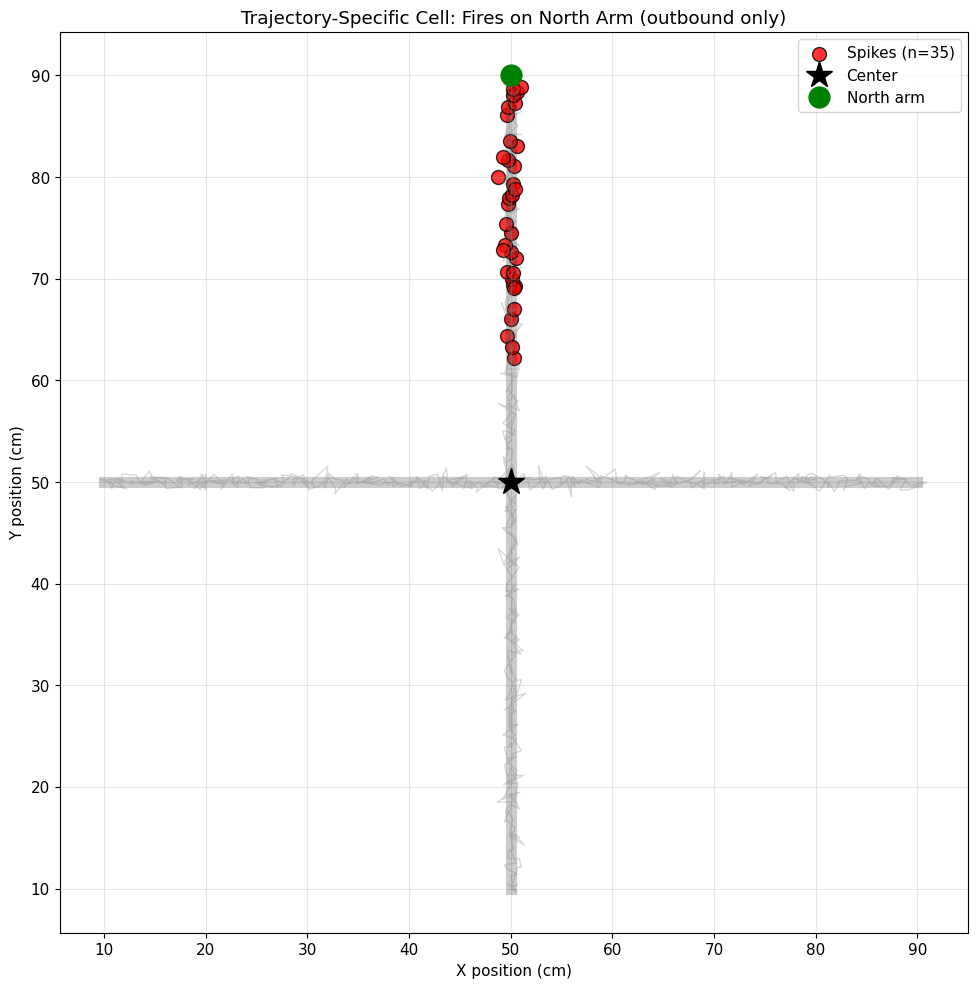


Notice: Cell fires specifically when animal moves toward north arm
But NOT when returning from north arm through the same physical space!


In [34]:
# Visualize spikes on 2D trajectory
fig, ax = plt.subplots(figsize=(10, 10))

# Draw maze structure
ax.plot(
    [center[0], north_end[0]], [center[1], north_end[1]], "k-", linewidth=8, alpha=0.2
)
ax.plot(
    [center[0], south_end[0]], [center[1], south_end[1]], "k-", linewidth=8, alpha=0.2
)
ax.plot(
    [west_end[0], east_end[0]], [center[1], center[1]], "k-", linewidth=8, alpha=0.2
)

# Plot trajectory
ax.plot(plus_maze_data[:, 0], plus_maze_data[:, 1], "gray", alpha=0.3, linewidth=1)

# Highlight spike locations
spike_indices = np.where(north_cell_spikes > 0)[0]
spike_positions = plus_maze_data[spike_indices]

ax.scatter(
    spike_positions[:, 0],
    spike_positions[:, 1],
    c="red",
    s=100,
    alpha=0.8,
    marker="o",
    edgecolors="black",
    linewidth=1,
    label=f"Spikes (n={len(spike_indices)})",
)

ax.plot(center[0], center[1], "k*", markersize=20, label="Center")
ax.plot(north_end[0], north_end[1], "go", markersize=15, label="North arm")

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Trajectory-Specific Cell: Fires on North Arm (outbound only)")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNotice: Cell fires specifically when animal moves toward north arm")
print("But NOT when returning from north arm through the same physical space!")

### Problem: 2D Analysis Misses Trajectory Dependence

If we compute a firing rate map in 2D space, we lose the trajectory information:

In [35]:
# Create 2D environment (wrong for this analysis!)
env_2d = Environment.from_samples(
    data_samples=plus_maze_data, bin_size=8.0, name="PlusMaze2D"
)

# Map to bins
bin_indices_2d = env_2d.bin_at(plus_maze_data)

# Compute firing rate
spike_counts_per_bin = np.bincount(
    bin_indices_2d[bin_indices_2d >= 0],
    weights=north_cell_spikes[bin_indices_2d >= 0],
    minlength=env_2d.n_bins,
)

occupancy_per_bin = (
    np.bincount(bin_indices_2d[bin_indices_2d >= 0], minlength=env_2d.n_bins) * 0.05
)

firing_rate_2d = np.divide(
    spike_counts_per_bin,
    occupancy_per_bin,
    where=occupancy_per_bin > 0,
    out=np.zeros_like(spike_counts_per_bin, dtype=float),
)

print(f"2D firing rate map: {env_2d.n_bins} bins")
print(f"Peak firing rate: {firing_rate_2d.max():.2f} Hz")

2D firing rate map: 44 bins
Peak firing rate: 18.46 Hz


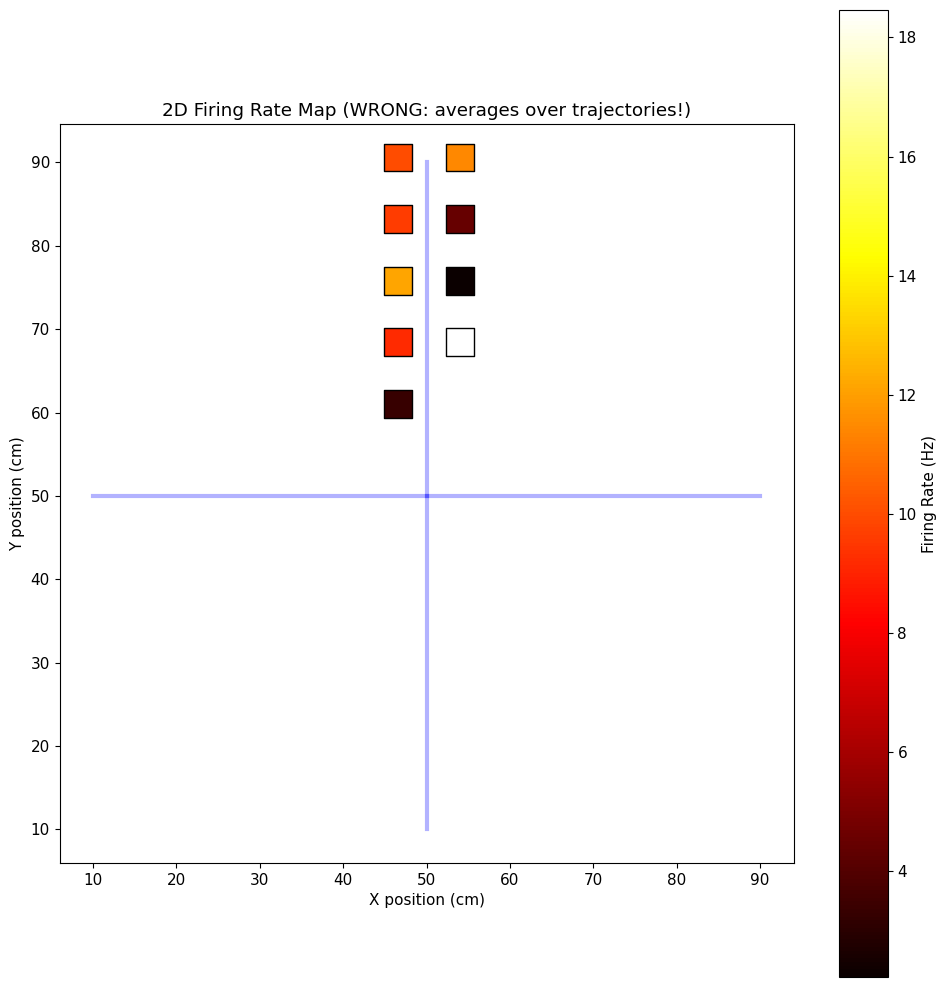


Problem: 2D map averages over outbound and inbound journeys
Result: Diluted place field, lost trajectory information


In [36]:
# Visualize 2D firing rate (problematic)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot firing rate
active_bins = firing_rate_2d > 0
scatter = ax.scatter(
    env_2d.bin_centers[active_bins, 0],
    env_2d.bin_centers[active_bins, 1],
    c=firing_rate_2d[active_bins],
    s=400,
    cmap="hot",
    marker="s",
    edgecolors="black",
    linewidth=1,
)

# Draw maze structure
ax.plot(
    [center[0], north_end[0]], [center[1], north_end[1]], "b-", linewidth=3, alpha=0.3
)
ax.plot(
    [center[0], south_end[0]], [center[1], south_end[1]], "b-", linewidth=3, alpha=0.3
)
ax.plot(
    [west_end[0], east_end[0]], [center[1], center[1]], "b-", linewidth=3, alpha=0.3
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("2D Firing Rate Map (WRONG: averages over trajectories!)")
ax.set_aspect("equal")
plt.colorbar(scatter, ax=ax, label="Firing Rate (Hz)")
plt.tight_layout()
plt.show()

print("\nProblem: 2D map averages over outbound and inbound journeys")
print("Result: Diluted place field, lost trajectory information")

### Solution: 1D Linearization Preserves Trajectory

Now let's see how 1D linearization handles this correctly:

In [37]:
if env_plus is not None and env_plus.is_1d:
    # Map to 1D bins
    bin_indices_1d = env_plus.bin_at(plus_maze_data)

    # Compute firing rate in 1D
    spike_counts_per_bin_1d = np.bincount(
        bin_indices_1d[bin_indices_1d >= 0],
        weights=north_cell_spikes[bin_indices_1d >= 0],
        minlength=env_plus.n_bins,
    )

    occupancy_per_bin_1d = (
        np.bincount(bin_indices_1d[bin_indices_1d >= 0], minlength=env_plus.n_bins)
        * 0.05
    )

    firing_rate_1d = np.divide(
        spike_counts_per_bin_1d,
        occupancy_per_bin_1d,
        where=occupancy_per_bin_1d > 0,
        out=np.zeros_like(spike_counts_per_bin_1d, dtype=float),
    )

    print(f"1D firing rate map: {env_plus.n_bins} bins")
    print(f"Peak firing rate: {firing_rate_1d.max():.2f} Hz")
    print("\nNotice: Peak rate is higher (not diluted by averaging)")
else:
    print("Skipping 1D analysis (track-linearization not available)")

1D firing rate map: 32 bins
Peak firing rate: 13.60 Hz

Notice: Peak rate is higher (not diluted by averaging)


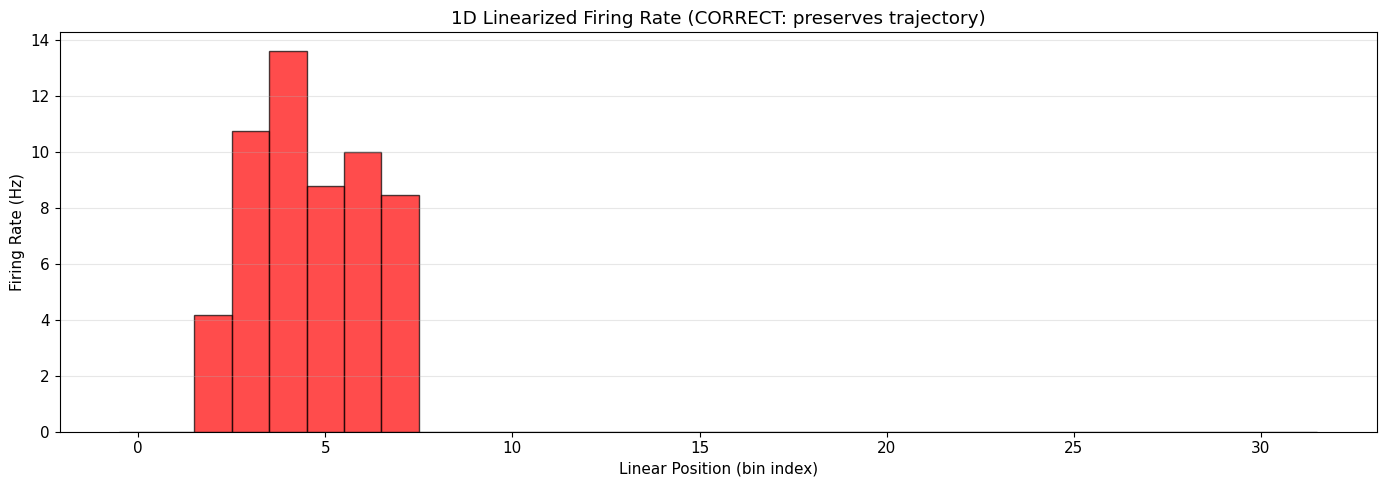


Success: Clear, localized place field on north arm
Outbound and inbound trajectories are separated!


In [38]:
if env_plus is not None and env_plus.is_1d:
    # Visualize 1D firing rate
    fig, ax = plt.subplots(figsize=(14, 5))

    # Get linear positions
    linear_pos = env_plus.to_linear(plus_maze_data)

    # Plot firing rate as function of linear position
    bin_linear_positions = np.arange(env_plus.n_bins)

    ax.bar(
        bin_linear_positions,
        firing_rate_1d,
        width=1.0,
        color="red",
        alpha=0.7,
        edgecolor="black",
        linewidth=1,
    )

    ax.set_xlabel("Linear Position (bin index)")
    ax.set_ylabel("Firing Rate (Hz)")
    ax.set_title("1D Linearized Firing Rate (CORRECT: preserves trajectory)")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nSuccess: Clear, localized place field on north arm")
    print("Outbound and inbound trajectories are separated!")
else:
    print("Skipping visualization (track-linearization not available)")

## When to Use 1D vs N-D Environments

| Use 1D (GraphLayout) | Use N-D (GridLayout) |
|---------------------|---------------------|
| Linear tracks | Open field arenas |
| Mazes with defined paths | Water mazes |
| Track-based tasks | Free exploration |
| Trajectory-dependent analysis | Purely spatial analysis |
| Sequence detection | Grid cell analysis |
| Theta sequences, replay | Head direction independence |

**Key question**: Does your analysis care about the trajectory/history, or just current location?
- **Trajectory matters** → Use 1D linearization
- **Location only** → Use N-D grids

## Checking if Environment is 1D

In [39]:
# Always check before calling linearization methods!


def safe_linearize(env, position):
    """
    Safely convert to linear position.

    Parameters
    ----------
    env : Environment
        Environment instance.
    position : ndarray
        Position data.

    Returns
    -------
    linear_position : ndarray or None
        Linear position if 1D, None otherwise.
    """
    if env.is_1d:
        return env.to_linear(position)
    else:
        print(f"Warning: {env.name} is not 1D (is {env.n_dims}D)")
        print("Use bin_at() instead for spatial binning")
        return None


# Test
print("Testing 2D environment:")
result = safe_linearize(env_2d, plus_maze_data[:10])

if env_plus is not None:
    print("\nTesting 1D environment:")
    result = safe_linearize(env_plus, plus_maze_data[:10])
    print(f"Linear positions: {result}")

Testing 2D environment:
Use bin_at() instead for spatial binning

Testing 1D environment:
Linear positions: [79.53768316 79.91942798 78.9951765  78.47029289 78.65145599 77.88099818
 77.92035148 77.07276178 77.00961968 76.15155339]


## Common Pitfalls

### Pitfall 1: Calling linearization methods on N-D environments

In [40]:
# ✗ WRONG - Don't call to_linear() on non-1D environments
try:
    linear = env_2d.to_linear(plus_maze_data[:10])
except TypeError as e:
    print(f"Error: {e}")
    print("\nAlways check env.is_1d before calling to_linear()!")

# ✓ CORRECT
if env_2d.is_1d:
    linear = env_2d.to_linear(plus_maze_data[:10])
else:
    print("Using spatial binning instead")
    bins = env_2d.bin_at(plus_maze_data[:10])

Error: Linearization is only available for 1D environments (GraphLayout). This environment has is_1d=False. Use Environment.from_graph() to create a 1D environment.

Always check env.is_1d before calling to_linear()!
Using spatial binning instead


### Pitfall 2: Using 2D environments for trajectory-dependent analysis

As we saw, this averages over different trajectories and loses information!

### Pitfall 3: Not providing track_graph for complex mazes

For simple tracks, auto-inference works. For complex mazes with branches, provide an explicit graph structure to ensure correct topology.

### Pitfall 4: Forgetting that linearization is trajectory-dependent

The same physical location maps to different linear positions depending on trajectory! This is a feature, not a bug.

## Key Takeaways

1. **1D linearization** maps 2D/3D positions onto a 1D track coordinate
2. **GraphLayout** creates 1D linearized environments (requires `track-linearization`)
3. **Use `from_graph()`** factory method with position data and optional track structure
4. **Trajectory-aware**: Same physical location → different linear positions based on path
5. **Essential for track tasks**: Plus mazes, T-mazes, linear tracks, figure-8s
6. **Check `env.is_1d`** before calling linearization methods
7. **Methods**:
   - `to_linear(nd_position)` - Convert to 1D
   - `linear_to_nd(linear_position)` - Convert back to N-D
8. **Benefits**: Trajectory-dependent analysis, sequence detection, better place fields

## Next Steps

You've completed the core tutorial series! You now know:

1. ✓ **Basics** (notebook 01) - Creating environments, spatial queries
2. ✓ **Layout engines** (notebook 02) - Regular, hexagonal, polygon-bounded
3. ✓ **Morphological operations** (notebook 03) - Handling sparse data
4. ✓ **Regions** (notebook 04) - Defining and analyzing zones
5. ✓ **Linearization** (notebook 05) - 1D track analysis

**Advanced topics to explore**:
- CompositeEnvironment (merging multiple environments)
- Alignment and transformations (mapping between environments)
- Custom layout engines (specialized discretizations)
- Integration with neural data pipelines

Check the documentation and examples directory for more!

## Exercises (Optional)

1. Create a figure-8 maze with explicit track graph
2. Simulate a place cell that fires on one arm but not others
3. Compare 2D vs 1D occupancy normalization for the same cell
4. Create a W-track environment and analyze directional place fields